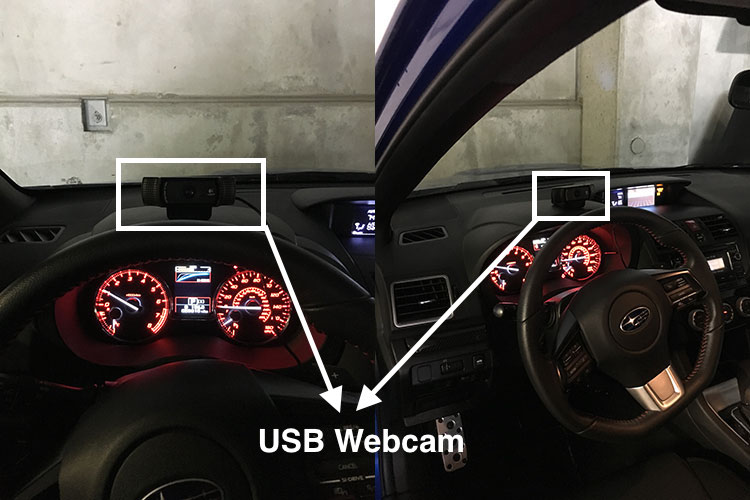

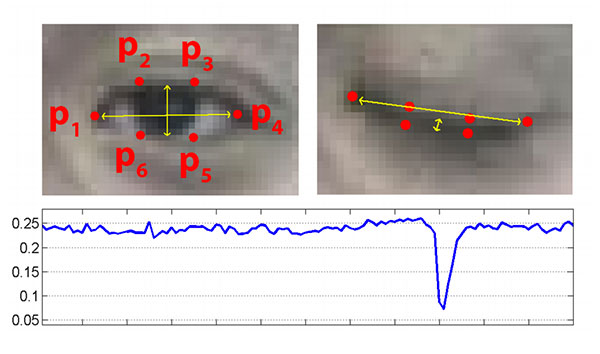

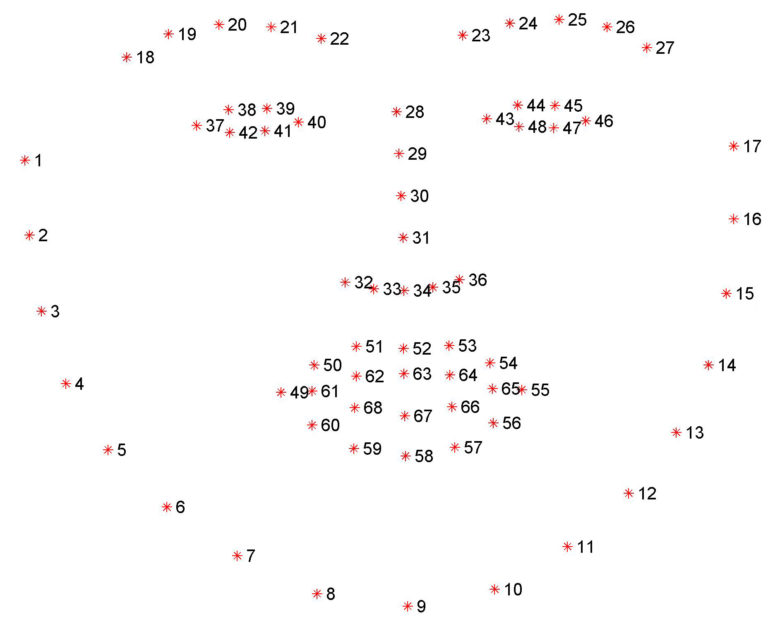

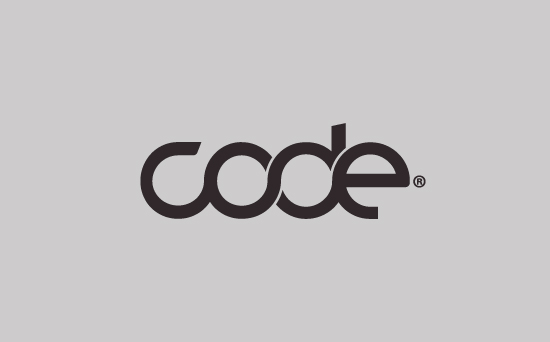

In [1]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
from threading import Thread
import numpy as np
import playsound
import imutils
import time
import dlib
import cv2


#***********************************************   
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
 
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])
 
	# compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)
 
	# return the eye aspect ratio
    return ear
#***********************************************
def sound_alarm(path):
	# play an alarm sound
    playsound.playsound(path)
#***********************************************
EYE_AR_THRESH = 0.31
EYE_AR_CONSEC_FRAMES = 50
COUNTER = 0
ALARM_ON = False
#***********************************************
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('face_landmarks.dat')
#***********************************************
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
#***********************************************
# start the video stream thread
print("[INFO] starting video stream thread...")
vs = VideoStream(src=0).start()
time.sleep(1.0)
 
# loop over frames from the video stream
while True:
	# grab the frame from the threaded video file stream, resize
	# it, and convert it to grayscale
	# channels)
    frame = vs.read()
    frame = imutils.resize(frame,width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale frame
    rects = detector(gray,0)
    # loop over the face detections
    for rect in rects:
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
 
		# extract the left and right eye coordinates, then 
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        # use the coordinates to compute the eye aspect ratio for both eyes
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
 
		# average the eye aspect ratio together for both eyes
        ear = (leftEAR + rightEAR) / 2.0
        
        # compute the convex hull for the left and right eye, then
		# visualize each of the eyes
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        
        # check to see if the eye aspect ratio is below the blink
		# threshold, and if so, increment the blink frame counter
        if ear < EYE_AR_THRESH:
            COUNTER += 1
 
			# if the eyes were closed for a sufficient number of
			# then sound the alarm
            if COUNTER >= EYE_AR_CONSEC_FRAMES:
                # if the alarm is not on, turn it on
                if not ALARM_ON:
                    ALARM_ON = True
 
					# check to see if an alarm file was supplied,
					# and if so, start a thread to have the alarm
					# sound played in the background
					#if args["alarm"] != "":
                    t = Thread(target=sound_alarm,
                        args=('alarm.wav',))
                    t.deamon = True
                    t.start()
 
				# draw an alarm on the frame
                cv2.putText(frame, "DROWSINESS ALERT!", (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
		# otherwise, the eye aspect ratio is not below the blink
		# threshold, so reset the counter and alarm
        else:
            COUNTER = 0
            ALARM_ON = False
            
        # draw the computed eye aspect ratio on the frame to help
		# with debugging and setting the correct eye aspect ratio
		# thresholds and frame counters
        cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255),2)
 # show the frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
 
	# if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
 
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream thread...
